In [1]:
%load_ext autoreload
%autoreload 2


## DriftMLP is the package implementing this methodology
import DriftMLP
## h3 to convert locations to their h3 indices.
## Where possible we use DriftMLP.helpers.return_h3_inds()
import h3.api.basic_int as h3

## core python packages
import os
import numpy as np #
import pandas as pd
import pickle
import gc


## Matplotlib for plotting
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc

## Cartopy for map projections
import cartopy.crs as ccrs
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns



## geopandas for aid storing Polygons and plotting
import geopandas as gpd
from shapely.geometry import Polygon


import string
alphabet = string.ascii_lowercase


driftfile = os.environ['DRIFTFILE'] 
### Generated by MakeDefNetworks
networks = pickle.load(open('default_networks.p', 'rb'))

### Only use drogued drifters
network = networks[True]
DriftMLP.helpers.remove_undesired(network)
postfix = 'drg'
del networks
### Our example locations are in locations.txt
stations = np.loadtxt("locations.txt", delimiter=',')
stations = pd.DataFrame(stations, index=range(1, 8))
stations.columns = ['Longitude', 'Latitude']
stations['h3'] = DriftMLP.helpers.return_h3_inds([i[['Longitude', 'Latitude']].to_list() for _,i in stations.iterrows()])
stations.loc[:,['Longitude', 'Latitude']].to_latex()
gc.collect()
print(sum([1 if len(i)>0 else 0 for i in network['stories']]))
DriftMLP.helpers.add_link(network)

22445
[2190, 36500]


In [2]:
print(sum([1 if len(i)>0 else 0 for i in network['stories']]))

22445


## Code above generates table1.

In [3]:
crs = ccrs.Robinson()

def cuts2poly(lon_left, lon_right, lat_bottom, lat_top):
    return Polygon(np.array([(lon_left, lat_bottom), (lon_right, lat_bottom),
                             (lon_right, lat_top), (lon_left, lat_top)]))


lon_ranges = [i for i in range(-180, 180, 5)]
lat_ranges = [i for i in range(-90, 90, 5)]

poly_limits = [(lon_ranges[i],
                lon_ranges[i+1],
                lat_ranges[j], lat_ranges[j+1])
               for i in range(len(lon_ranges)-1)
               for j in range(len(lat_ranges)-1)]

poly_centers = [((i[1]+i[0])/2, (i[3]+i[2])/2) for i in poly_limits]

h3_centers = DriftMLP.helpers.return_h3_inds(poly_centers)

polygons = [cuts2poly(*poly_limit) for poly_limit in poly_limits]

all_paths = DriftMLP.shortest_path.get_all_paths(network, stations.iloc[0,2], h3_centers)
tts = [path.travel_time for path in all_paths]

dat = gpd.GeoDataFrame(
    {'geometry': polygons, 'traveltime': tts}, crs=None)
## Drop land polygons, and non accesible polygons.
plot_data = dat.query('traveltime>0')
plot_data['traveltime'] = plot_data.loc[:,'traveltime']/365
display(plot_data)


/home/omalley3/Documents/PhD_Docs/pydrifter_dev/DriftMLP/shortest_path/__init__.py:65: RuntimeWarning: Couldn't reach some vertices at /home/conda/feedstock_root/build_artifacts/python-igraph_1588168236277/work/vendor/source/igraph/src/structural_properties.c:4726
  sps = network.get_shortest_paths(from_node, to_nodes, weights='neglogprob')
/home/omalley3/anaconda3/envs/driftmlp/lib/python3.8/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,geometry,traveltime
5,"POLYGON ((-180.00000 -65.00000, -175.00000 -65...",4.377140
6,"POLYGON ((-180.00000 -60.00000, -175.00000 -60...",4.351713
7,"POLYGON ((-180.00000 -55.00000, -175.00000 -55...",4.359729
8,"POLYGON ((-180.00000 -50.00000, -175.00000 -50...",4.297398
9,"POLYGON ((-180.00000 -45.00000, -175.00000 -45...",4.635065
...,...,...
2476,"POLYGON ((170.00000 40.00000, 175.00000 40.000...",8.864568
2477,"POLYGON ((170.00000 45.00000, 175.00000 45.000...",9.211898
2478,"POLYGON ((170.00000 50.00000, 175.00000 50.000...",8.649217
2479,"POLYGON ((170.00000 55.00000, 175.00000 55.000...",9.439772


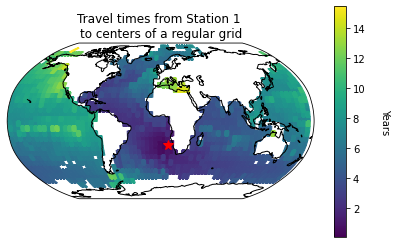

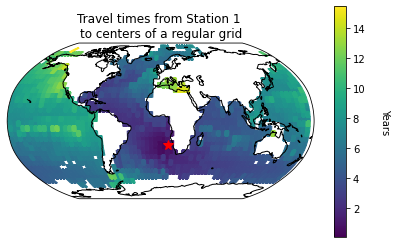

In [4]:
## Color bar settings
cmap = plt.get_cmap('viridis')
norm = plt.Normalize()
norm.autoscale(plot_data['traveltime'])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)



crs = ccrs.Robinson()
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs},
                        figsize=(5.5, 4))

# Make the CartoPy plot by adding the polygons colored by the travel time
for color, rows in plot_data.groupby('traveltime'):
    color_mapped = sm.cmap(norm(color))
    axs.add_geometries(rows['geometry'], crs=ccrs.PlateCarree(),
                       facecolor=color_mapped, edgecolor=color_mapped)
axs.coastlines()
cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])  # x0 y0 width height

mpl.colorbar.ColorbarBase(cax,
                          cmap=cmap,
                          norm=norm)
cax.set_ylabel('Years', labelpad=25, rotation=270)
axs.set_title("Travel times from Station 1 \nto centers of a regular grid")
source = stations.loc[1]
q = axs.get_extent()
axs.plot(source['Longitude'], source['Latitude'], '*',
         color='red', markersize=10, transform=ccrs.Geodetic())
axs.set_extent(q, crs=crs)
fig.savefig(f"Images/tt1_{postfix}.png", bbox_inches='tight')
#fig.savefig("/home/omalley3//tt1_drg.pdf", bbox_inches='tight')
fig

[[26747, 13841, 26494, 9876, 23250, 14446, 4902, 16965, 11474, 27509, 17388, 20025, 23311, 25995, 24624, 3946, 21122, 27066, 23138, 8363, 19904, 26510, 3388, 27294, 15420, 13469, 3603, 17611, 12031, 14384, 17255, 1361, 10013, 7642, 2539, 15808, 18636, 25507, 9012, 9188, 7043, 26044, 12083, 17437, 7008, 744, 26868, 10511, 22210, 13290, 10969, 3624, 11778, 27344, 27154, 16372, 25835, 6082, 7550, 10984, 13803, 10970, 26321, 25386, 14145, 12148, 9120, 14056, 10568, 27116, 26392, 10795, 401, 22065, 11338, 1245, 17678, 22077]]
590444959660769279
593000362122674175
None
From: [9.0, -25.5], To: [-40, 43]
Travel time for the forward journey(blue)
1178.3212576446986
Travel time for the return journey(red)
1952.750528272767



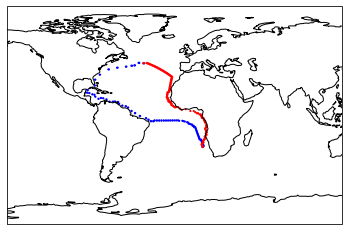

In [5]:
loc1 = stations.iloc[0,[0,1]].to_list()
loc2 = [-40,43]
sp = DriftMLP.shortest_path.SingleSP(network, loc1, loc2)
print(sp.sp.all_sps)
print(sp.sp.dest)
print(sp.sp.src)
print(sp.sp.error_msg)
sp.plot_cartopy()

print(DriftMLP.shortest_path.SingleSP(network, loc1, loc2))

## Figure 5 is in Latex tikz image

## Code for making Figure 6 Below
 
 - This figure is made to show how the method succesfully follows currents

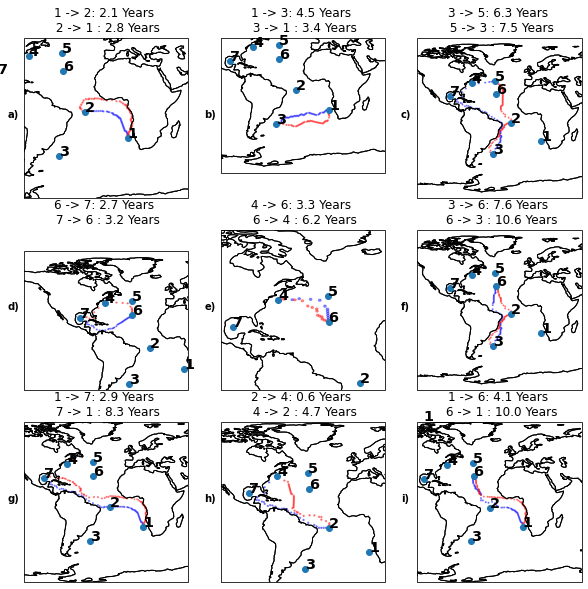

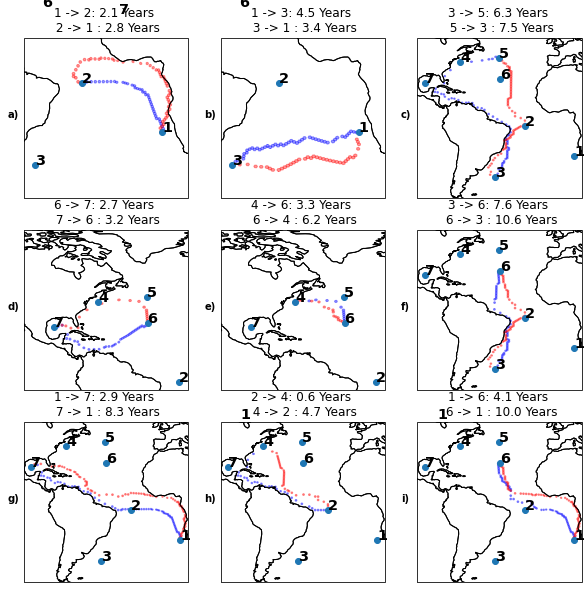

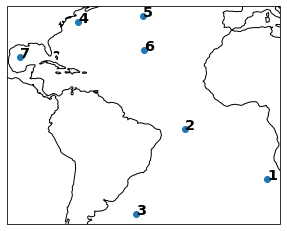

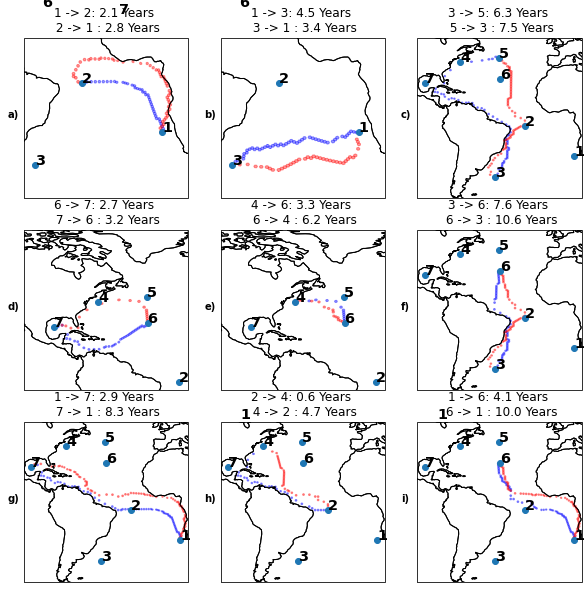

In [6]:
ods = [[0, 1], [0, 2], [2, 4], [5, 6], [3, 5], [2, 5], [0, 6], [1, 3], [0, 5]]
plt.figure()
from DriftMLP.plotting.general import plot_stations
ax = plot_stations(stations, names= stations.index)
exts = [ax.get_extent(), [-50, 20, -40, 5], [-110, -20, 1, 60]]
which_ext = [1, 1, 0, 2, 2, 0, 0, 0, 0]

def plot_there_back(od, stations, network, ax):
    loc_from, loc_to = [stations.iloc[i].loc[['Longitude', 'Latitude']].to_list()
                        for i in od]
    plot_stations(stations,names=stations.index, ax= ax)
    sp = DriftMLP.shortest_path.SingleSP(network, loc_from,loc_to)
    sp.plot_cartopy(gpd_df= network['gpd'], ax=ax, alpha=0.4)
    return sp

fig = plt.figure(figsize=(10, 10))
subplots_shape = [3, 3]
for i in range(min(len(ods), 9)):
    ax = plt.subplot(
        subplots_shape[0], subplots_shape[1],
        i+1, projection=ccrs.PlateCarree())
    #current_ext = exts[which_ext[i]]
    #oscar_arrows(cubes[zonal], cubes[mer], lon_range=current_ext[:2],
    #             lat_range=current_ext[2:4], res=[2, 2], axes=ax)
    sp = plot_there_back(ods[i], stations, network, ax=ax)
    tt1 = sp.sp.travel_time
    tt2 = sp.sp_rev.travel_time
    #ax.set_extent(exts[which_ext[i]])
    from_st, to_st = ods[i]
    ax.set_title(
        "{} -> {}: {} Years \n {} -> {} : {} Years".
        format(from_st+1, to_st+1, round(tt1/365, 1),
               to_st+1, from_st+1, round(tt2/365, 1)))
    plot_num = alphabet[i]
    ax.text(-0.1, 0.5, "{})".format(plot_num),
            transform=ax.transAxes, fontweight='bold')
display(fig)
for ax, ext_ind in zip(fig.axes, which_ext):
    ax.set_extent(exts[ext_ind])
display(fig)
fig.savefig(f'Images/pathways_{postfix}.pdf', bbox_inches='tight')

## Code for Fig7 below
- Plot travel times to everywhere on the world just for an example

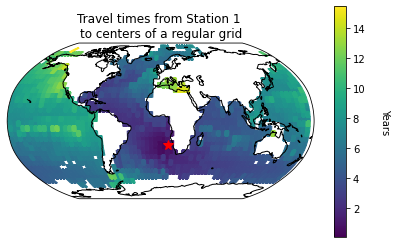

In [7]:
## Color bar settings
cmap = plt.get_cmap('viridis')
norm = plt.Normalize()
norm.autoscale(plot_data['traveltime'])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)



crs = ccrs.Robinson()
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs},
                        figsize=(5.5, 4))

# Make the CartoPy plot by adding the polygons colored by the travel time
for color, rows in plot_data.groupby('traveltime'):
    color_mapped = sm.cmap(norm(color))
    axs.add_geometries(rows['geometry'], crs=ccrs.PlateCarree(),
                       facecolor=color_mapped, edgecolor=color_mapped)
axs.coastlines()
cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])  # x0 y0 width height

mpl.colorbar.ColorbarBase(cax,
                          cmap=cmap,
                          norm=norm)
cax.set_ylabel('Years', labelpad=25, rotation=270)
axs.set_title("Travel times from Station 1 \nto centers of a regular grid")
source = stations.loc[1]
q = axs.get_extent()
axs.plot(source['Longitude'], source['Latitude'], '*',
         color='red', markersize=10, transform=ccrs.Geodetic())
axs.set_extent(q, crs=crs)
fig.savefig(f"Images/tt1_{postfix}.png", bbox_inches='tight')
fig.savefig(f"Images/tt1_{postfix}.pdf", bbox_inches='tight')

## Figure 8

9.518689956280566
11.439173843718626


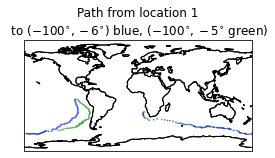

In [8]:
fig, ax = plt.subplots(1,1, subplot_kw = {'projection':ccrs.PlateCarree()},figsize =(4,2.3))
rc('text', usetex=True)
loc1 = stations.iloc[0].loc[['Longitude', 'Latitude']].to_list()
path1 = DriftMLP.shortest_path.SingleSP(network, loc1 ,[-100,-5])
path2 = DriftMLP.shortest_path.SingleSP(network, loc1 ,[-100,-6])
path1.plot_cartopy(ax= ax, gpd_df = network['gpd'], rev=False, color='green',alpha=0.3)
path2.plot_cartopy(ax= ax, gpd_df = network['gpd'], rev=False, alpha=0.3)
print(path1.sp.travel_time/365)
print(path2.sp.travel_time/365)
ax.set_title('Path from location 1\n to ($-100^{\circ},-6^{\circ})$ blue, ($-100^{\circ},-5^{\circ}$ green)')
ax.axis('auto')
fig.tight_layout()
fig.savefig(f'Images/example_path_{postfix}.pdf')
fig.savefig(f'Images/example_path_{postfix}.png')
rc('text', usetex=False)

# Note: 
the following uses results from a computationally intensive script, hence why we load in data which was generated by a script.

rotations_x.p generates x random rotation matrices. This is produced from MakeRotations.py. It requires roughly 1gb ram per parallel process. The run time is approximately x*3/num_processes. Rotations_100.p took me approximately 1.5 hours to make.


In addition to this the below is quite heavy to run as we load in 100 rotation networks taking around 8gb of ram. In practical applications it would be better just to store the pathways and the rotation used for the particular application instead of making Rotations_100.p. That way the networks do not need to be saved, which makes this script light to run.

- The neccesary gpd's can be made purely from the rotation and the h3 indices in the pathways using DriftMLP.plotting.make_h3_gpd 

I stored the networks for experimental purposes. It allows me to have the flexibility to add extra locations if needed.

# Figure 7


In [ ]:
nets = pickle.load(open('rotations_100.p', 'rb'))
origins = [stations.iloc[i].loc[['Longitude', 'Latitude']].to_list() for i in range(stations.shape[0])]
print(origins)
plot_n=len(nets)
from shapely.geometry import Point
def path_and_df(network, original_gpd):
    indices = DriftMLP.helpers.return_h3_inds(origins, rot=network['rotation'])
    paths = [DriftMLP.shortest_path.get_all_paths(network, src, indices) for src in  indices]
    ##We didn't store all the gpd dataframes originally as its' costly memorywise
    rot = network['rotation']
    h3_df = DriftMLP.plotting.make_h3_gpd.network_to_multipolygon_df(network)
    return {'paths':paths, 'gpd':h3_df, 'rot':rot}
#%timeit path_and_df(nets[5],network['gpd'])
res = []
for i in range(plot_n):
    res.append(path_and_df(nets[i], network['gpd']))
#del nets

In [ ]:
travel_times = np.array([
    [
        [path.travel_time for path in list_of_paths]
    for list_of_paths in res[i]['paths']]
for i in range(len(res))])
print(travel_times.shape)
mean_tts = travel_times.mean(axis=0)
var_tts = travel_times.var(axis=0,ddof=1)
err = np.array([travel_times[:i,:,:].mean(axis=0)-mean_tts for i in range(1,11)])
np.where(var_tts==np.max(var_tts))

In [ ]:
from shapely.geometry import Point


def plot_rotated_line(h3_gpd, h3_ids, ax, *args,**kwargs):
    h3_rot = h3_gpd.loc[h3_ids]
    DriftMLP.plotting.h3_cartopy.plot_line(h3_rot, h3_ids,'rotated_centroid', ax=ax, fig_init=False, *args, **kwargs)


fig = plt.figure(figsize = (10,10))
for i in range(min(len(ods),9)):
    ax = plt.subplot(subplots_shape[0], subplots_shape[1], i+1, projection=ccrs.PlateCarree())
    from_st = ods[i][0]
    to_st = ods[i][1]
    fl = True
    for res_dict in res[:plot_n]:
        plot_rotated_line(res_dict['gpd'], 
                          res_dict['paths'][from_st][to_st].h3id,
                          ax,
                          alpha=0.01, fl=False ,color='blue')
        plot_rotated_line(res_dict['gpd'], 
                          res_dict['paths'][to_st][from_st].h3id,
                          ax,
                          alpha=0.01, fl=False ,color='red')
    DriftMLP.plotting.general.plot_stations(stations, ax=ax, names=list(range(1,8)))
    ax.set_extent(exts[which_ext[i]])
    tt1 = mean_tts[ods[i][0], ods[i][1]]
    tt2 = mean_tts[ods[i][1], ods[i][0]]
    var1 = var_tts[from_st, to_st]
    var2 = var_tts[to_st, from_st]
    
    ax.set_title("{} -> {}: {}(sd {}) Years \n {} -> {} : {}(sd {}) Years".format(
        ods[i][0]+1, ods[i][1]+1, round(tt1/365,1), round(np.sqrt(var1)/365, 1),
        ods[i][1]+1, ods[i][0]+1, round(tt2/365,1), round(np.sqrt(var2)/365, 1)))
    plot_num = alphabet[i]
    ax.text(-0.1,0.5,"{})".format(plot_num),transform = ax.transAxes, fontweight='bold')
    ax.set_adjustable('datalim')

    ax.coastlines()
#fig.savefig('Images/rotation_results.pdf', bbox_inches='tight')
fig.savefig('Images/rotation_results.png', bbox_inches='tight')
del res
gc.collect()

# Figure 10

In [ ]:
i=0
new_pos = [stations.iloc[i,0], stations.iloc[i,1]-0.7]
stat1 = [stations.iloc[i,0], stations.iloc[i,1]]
import matplotlib.gridspec as gridspec
def get_tt(network):
    return DriftMLP.shortest_path.SingleSP(network, new_pos, stat1, rot=network['rotation'])
sps = [get_tt(net) for net in nets]
no_rot = get_tt(network)
non_zeros = [sp.sp.travel_time for sp in sps if sp.sp.travel_time!=0]
non_zeros_ret = [sp.sp_rev.travel_time for sp in sps if sp.sp_rev.travel_time !=0]
fig = plt.figure(figsize=(4,3))
gs = fig.add_gridspec(2, 2)
ax = plt.subplot(gs[0,:], projection=ccrs.PlateCarree())
no_rot.plot_cartopy(ax=ax, color='blue', alpha=0.2,rev=False)
ax.set_extent([6,12,-28,-24])

ax.plot(stations.iloc[i,0], stations.iloc[i,1],'r*', transform=ccrs.PlateCarree())
ax.plot(new_pos[0], new_pos[1],'b*', transform=ccrs.PlateCarree())
#gt_plot.add_standard_gridlines(ax, x_locs = [-180]+list(range(6,12,2))+[180], y_locs = list(range(-28,-24)))

ax_bar = plt.subplot(gs[1,0])
ax_ret = plt.subplot(gs[1,1], sharex=ax_bar)
ax_bar.set(xlabel='Travel time (days)', ylabel='Frequency', title='red -> blue')

sns.distplot(non_zeros, ax =ax_bar, kde = False)
sns.distplot(non_zeros_ret, ax =ax_ret, kde=False)
ax_bar.set_xlim([0,50])
ax_ret.set(xlabel='Travel time (days)', ylabel='', title='blue -> red')
plt.subplots_adjust(hspace=0.4)
ax.axis('auto')
ax.set_extent([6,12,-28,-24])
#fig.tight_layout()
fig.savefig('Images/samegrid.pdf',bbox_inches='tight')
fig.savefig('Images/samegrid.png',bbox_inches='tight')
print(len(non_zeros))
print(np.mean(non_zeros))
print(np.mean([sp.sp.travel_time for sp in sps]))
print(np.mean([sp.sp_rev.travel_time for sp in sps]))

# Figure 9

In [ ]:
bootstrap_paths = pickle.load(open('bootstrapped_drg_200.p', 'rb'))
n_boot = len(bootstrap_paths)
def get_attr_from_nestedlists(nestedlists, attr_name):
    return [[getattr(path, attr_name) for path in list_of_paths] for list_of_paths in nestedlists]
bootstrap_traveltimes= np.array([get_attr_from_nestedlists(path_collection, 'travel_time') for path_collection in bootstrap_paths])
bootstrap_tt_mean = bootstrap_traveltimes.mean(axis=0)
bootstrap_tt_var= bootstrap_traveltimes.var(axis=0, ddof=1)

In [ ]:
bootstrap_tt_mean
od_example = [0,2]
from_st = od_example[0]
to_st = od_example[1]
bootstrap_to = [nested_list[from_st][to_st] for nested_list in bootstrap_paths]
bootstrap_back = [nested_list[to_st][from_st] for nested_list in bootstrap_paths]

In [ ]:

fig = plt.figure(figsize=(5,3))
gs = fig.add_gridspec(2, 2)
ax_bar = fig.add_subplot(gs[0,1])
ax_bar_ret = fig.add_subplot(gs[0,0], sharex = ax_bar)
ax_map = fig.add_subplot(gs[1,:], projection = ccrs.PlateCarree())


sns.distplot(bootstrap_traveltimes[:,from_st,to_st]/365, ax=ax_bar,color='red')
sns.distplot(bootstrap_traveltimes[:,to_st,from_st]/365, ax=ax_bar_ret, color='blue')
loc_from = stations[['Longitude', 'Latitude']].iloc[from_st].to_list()
loc_to =stations[['Longitude', 'Latitude']].iloc[to_st].to_list()
sp = DriftMLP.shortest_path.SingleSP(network, loc_from,loc_to)
ax_bar.set_title('Bootstrap Times: 3 - > 1')
ax_bar_ret.set_title('Bootstrap Times: 1 - > 3')
ax_bar.axvline(sp.sp.travel_time/365)
#ax_bar.axvline(mean_tts[from_st, to_st]/365, color='red')
#ax_bar.axvline(bootstrap_tt_mean[from_st,to_st]/365)
ax_bar.set_xlabel('Years')
ax_bar_ret.set_xlabel('Years')


ax_bar_ret.axvline(sp.sp_rev.travel_time/365)
#ax_bar_ret.axvline(mean_tts[to_st, from_st]/365, color='red')
ax_bar_ret.legend()
#ax_bar_ret.axvline(bootstrap_tt_mean[to_st,from_st]/365, label='Bootstrap')
#h3_vis.plot_hex(network['gpd'], path,alpha=0.2,  ax=ax_map,facecolor="None" ,edgecolor='red')
#h3_vis.plot_hex(h3_gpd, path_ret,alpha=0.2,  ax=ax_map, facecolor="None" ,edgecolor='blue')

plot_there_back(od_example,stations,network, ax= ax_map)


for i in range(n_boot):
    plot_rotated_line(network['gpd'], 
                          bootstrap_to[i].h3id,
                          ax=ax_map,
                          alpha=0.01, fl=False ,color='blue')
    plot_rotated_line(network['gpd'], 
                          bootstrap_back[i].h3id,
                          ax_map,
                          alpha=0.01, fl=False ,color='red')
ax_map.coastlines()
ax_map.axis('auto')
DriftMLP.plotting.general.plot_stations(stations, ax=ax_map)
ax_map.set_extent([-50,20,-40,-10])
plt.subplots_adjust(hspace=0.3)
gl = ax_map.gridlines(draw_labels=True)
gl.top_labels= False
gl.left_labels = True
gl.xlabels_right = False
gl.xlines = False
gl.xlocator = mticker.FixedLocator(range(-60,60,20))
gl.ylocator = mticker.FixedLocator(range(-80,0,10))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

fig.savefig('Images/Bootstrap_Ex.pdf', bbox_inches='tight')
fig.savefig('Images/Bootstrap_Ex.png', bbox_inches='tight')
print(f"Going from {from_st} , to {to_st},"
      f"full_tt: {sp.sp.travel_time/365}"
      f" mean: {bootstrap_tt_mean[from_st, to_st]/365}"
      f" std: {np.sqrt(bootstrap_tt_var[from_st, to_st]/(365**2))}"
     f"rot_mean: {mean_tts[from_st, to_st]/365}")
print(f"Going from {to_st} , to {from_st},"
      f"full_tt: {sp.sp_rev.travel_time/365}"
      f" mean: {bootstrap_tt_mean[to_st, from_st]/365}"
      f" std: {np.sqrt(bootstrap_tt_var[to_st, from_st]/(365**2))}"
      f"rot_mean: {mean_tts[to_st, from_st]/365}")

## How many paths go into/out of the med out of the 100

In [ ]:
p_med = [16.5, 34.7]
loc1 = stations[['Longitude','Latitude']].iloc[0].to_list()
def get_tt(network):
    return DriftMLP.shortest_path.SingleSP(network, p_med, loc1, rot=network['rotation'])
sp_out_of_med = [] 
for rot_network in nets:
    sp_out_of_med.append(get_tt(rot_network))
sp_out = [sp.sp.travel_time for sp in sp_out_of_med]
sp_in = [sp.sp_rev.travel_time for sp in sp_out_of_med]
print(len([tt for tt in sp_out if tt>0]))
print(len([tt for tt in sp_in if tt>0]))

In [ ]:
sp.sp_rev.travel_time/365

In [ ]:
SP_3_5 = DriftMLP.shortest_path.SingleSP(network, stations[['Longitude','Latitude']].iloc[2].to_list(), stations[['Longitude','Latitude']].iloc[4].to_list())

In [ ]:
plt.plot(np.cumsum(SP_3_5.sp.travel_time_list))
plt.axvline(21)
print(np.sum(SP_3_5.sp.travel_time_list[0:21])/365)

In [ ]:
from DriftMLP.plotting.h3_plotly import visualize_hexagons

In [ ]:
m = visualize_hexagons(SP_3_5.sp.h3id[0:21], color='red')
m = visualize_hexagons(SP_3_5.sp.h3id[21:], color='blue', folium_map=m)
m